# Efficient Frontier - Justin Do & Defne Sener

---

## **Primary Objective:** For this project, you will select a basket of seven (7) assets, calculate their individual risk/return value, combine these into the efficient frontier, and then plot the results.

---

### Starting with our packages:
- Yahoo Finance --> for data on our chosen tickers/assets
- Numpy --> Choosing random integers for our simulation
- Pandas --> Usage of Dataframe for easier calculations
- Matplotlib --> Graphing our simulation 

In [1]:
import yfinance as yf 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Step 1:
Choose seven (7) assets (preferably something with significant historical data)

In [2]:
tickers = ['AAPL', 'V', 'HD', 'KO', 'JNJ', 'AMGN', "NVDA"] # Apple Inc., Visa Inc., The Home Depot, Inc., The Coca-Cola Company, Johnson & Johnson, Amgen Inc., NVIDIA Corporation
# we're also going to set the number of assets and simulations 
num_of_assets = len(tickers)
num_of_sim = 200000

## Step 2:
Retrieve daily open or close data on your assets for the previous 2 years

In [3]:
period = '2y'
_2_year_data = yf.download(tickers, period=period)['Adj Close'].pct_change()
# _2_year_data = _2_year_data.drop(_2_year_data.index[0]) # drop the first na
data_df = pd.DataFrame(index=tickers)

# we're also going to create our montecarlo df which will hold the wieght of each asset, portfolio weighted var & return, and sharpe ratio
monte_carlo_outcomes = pd.DataFrame(columns=tickers)

[*********************100%***********************]  7 of 7 completed


## Step 3:
Calculate the mean, variance, and correlation matrix for all assets

In [4]:
# calculating mean --> the average price of our assets
data_df['Asset Average Returns'] = (_2_year_data * 100).mean()

# calculating the variance --> returns = pct_change * 100 then we could get variance from it
data_df['Asset Variance for Percent Change'] = (_2_year_data * 100).var()

# calculating the correlation matrix between our stocks
corr_matrix = _2_year_data.pct_change().corr()

## Step 4:
Calculate efficient frontier and optimal weights for your portfolio (Don’t forget the output!)

In [5]:
# Let's start with making a function to calculate the sharpe ratio 
# since we'll be using that in our function that calculates wieghted variance and return 

class Portfolio:
    def __init__(self, num_of_assets, num_of_sim):
        self.num_of_assets = num_of_assets
        self.num_of_sim = num_of_sim
        
    # my methods 
    def cal_sharpe_ratio(self, weighted_return, weighted_var, risk_free_rate=0):
        # normally the formula would be: (weighted_return - risk_free_rate)/stdev_port but we care about the relationship of the sharpe ratio not the number
        return (weighted_return - risk_free_rate)/weighted_var

    
    def cal_weighted_var_return(self, weight_df, sim):
        """
        :param weight_df: weight series of all our assets
        :param sim: the current simulation of our assets. We're using this to update the Portfolio Weighted returns and var
        :return: None; we're updating the monte_carlo_outcomes DataFrame
        """

        portfolio_weighted_var = 0
        portfolio_weighted_return = 0

        for asset in tickers:
            asset_weight = weight_df[asset]/100 # has to be a percentage before multiplying
            asset_variance = data_df.loc[asset]['Asset Variance for Percent Change']    # extracting a row
            asset_return = data_df.loc[asset]['Asset Average Returns']

            portfolio_weighted_var += round((asset_weight * asset_variance), 3)
            portfolio_weighted_return += round((asset_weight * asset_return), 3)

        # once we went over all our assets we need to add a column with these values
        monte_carlo_outcomes.loc[sim,'Portfolio Weighted Variance'] = float(portfolio_weighted_var)    # these are set as series so we're going to convert them into floats
        monte_carlo_outcomes.loc[sim,'Portfolio Weighted Return'] = float(portfolio_weighted_return)

        # Having the weighted var and return we could being implementing our sharpe ratio
        sharpe_ratio = self.cal_sharpe_ratio(float(portfolio_weighted_return), float(portfolio_weighted_var)) # by default the risk_free_rate is 0 from our function
        monte_carlo_outcomes.loc[sim,'Portfolio Weighted Sharpe Ratio'] = sharpe_ratio
    
    
    def cal_monte_carlo(self):
        # all the weight must equal to 100
        global monte_carlo_outcomes # referencing to our global variable
        self.num_of_assets =num_of_assets 
        self.num_of_sim = num_of_sim
        progress = [0.25*num_of_sim, 0.50*num_of_sim, 0.75*num_of_sim, 0.9 * num_of_sim]
        possible_weight = 100
        for sim in range(num_of_sim):
            weight = []

            """
            we're going to keep running this loop to find combinations until:
                - We have weights that are equal to the number of assets (one weight for each) 
                - The combination isn't the same as the one's we already have in our dataframe
                - All weights are equal to 100
            """
            # we could add any columns without comparison problems by getting values from our df that deals with weight
            while len(weight) != num_of_assets \
                    or weight in monte_carlo_outcomes[tickers].values.tolist()\
                    or np.sum(weight) != 100:
                for asset_index in range(num_of_assets):
                    if asset_index == (num_of_assets - 1):
                        asset_weight = possible_weight
                    elif possible_weight > 1:  # using high and low, we cannot have or high <= 1
                        asset_weight = np.random.randint(low=1, high=possible_weight)
                    else:   # for our flawed combination, let's try to find another one instead of breaking
                        # reset the weights and possible_weight to keep the while loop going and input new numbers
                        weight = []
                        possible_weight = 100
                        break   # we need to break out of the for loop and sit in the while loop

                    possible_weight -= asset_weight
                    weight.append(asset_weight)

            # if we reach here, we have weights for every asset that doesn't exist in our monte_carlo_outcomes
            weight = pd.DataFrame([weight], columns=tickers)    # Shape of df is (3,3) so we need our weight to be (3,3)
            monte_carlo_outcomes = pd.concat([monte_carlo_outcomes, weight], ignore_index=True)
            # now that we have the weights... we need to calculate the weighted var and return
            self.cal_weighted_var_return(weight, sim)
            # once we finish with one sim we need to reset our possible weight
            possible_weight = 100
            if sim in progress:
                print(sim)

        # Once we finish all of our simulations we'll sum them and make sure all weights are 100
        monte_carlo_outcomes['Total Weight'] = monte_carlo_outcomes[tickers].sum(axis=1)
        

In [19]:
our_port = Portfolio(num_of_assets, num_of_sim)
our_port.cal_monte_carlo()  # running this method from our class Portfolio will not return anything. It only alters our monte_carlo_outcomes df 

## Step 5 & 6:
- Use MatPlotLib or Seaborn libraries to graph the results (matrix and frontier)
- Output the calculated optimal weighting (identify portfolio weightings for optimum Sharpe Ratio) along with the efficient frontier and correlation matrix charts. Output to a saved file.

Text(0.5, 1.0, '241000 Portfolio')

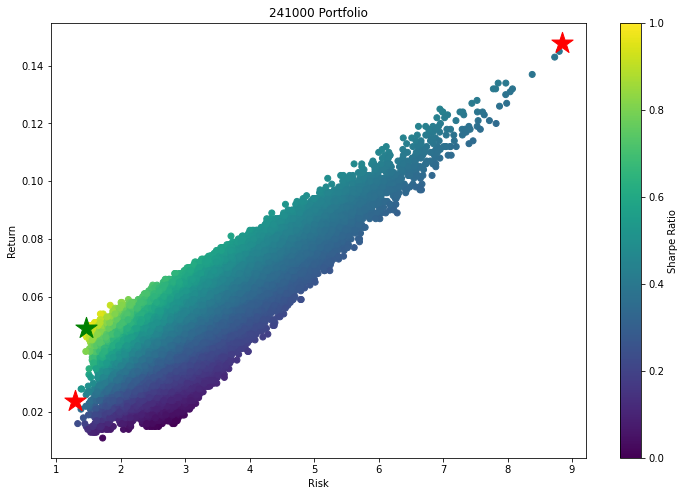

In [20]:
# Using MatPlotLib to graph the results

# Efficient Frontier 
x = monte_carlo_outcomes['Portfolio Weighted Variance']
y = monte_carlo_outcomes['Portfolio Weighted Return']
c = monte_carlo_outcomes['Portfolio Weighted Sharpe Ratio']

min_vol_port = monte_carlo_outcomes.loc[monte_carlo_outcomes['Portfolio Weighted Variance'] == monte_carlo_outcomes['Portfolio Weighted Variance'].min()]
optimal_port = monte_carlo_outcomes.loc[monte_carlo_outcomes['Portfolio Weighted Sharpe Ratio'] == monte_carlo_outcomes['Portfolio Weighted Sharpe Ratio'].max()] # where the sharpe ratio is max 
max_vol_port = monte_carlo_outcomes.loc[monte_carlo_outcomes['Portfolio Weighted Variance'] == monte_carlo_outcomes['Portfolio Weighted Variance'].max()]

plt.figure(figsize=(12,8))
plt.scatter(x, y, c=c, cmap='viridis')
plt.scatter(min_vol_port['Portfolio Weighted Variance'], min_vol_port['Portfolio Weighted Return'], cmap='viridis', color='r', marker='*', s=500)
plt.scatter(optimal_port['Portfolio Weighted Variance'], optimal_port['Portfolio Weighted Return'], cmap='viridis', color='g', marker='*', s=500)
plt.scatter(max_vol_port['Portfolio Weighted Variance'], max_vol_port['Portfolio Weighted Return'], cmap='viridis', color='r', marker='*', s=500)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.title(f'{monte_carlo_outcomes.shape[0]} Portfolio')

In [21]:
# Graphing our correlation matrix
corr_matrix.style.background_gradient(cmap='coolwarm').format(precision=2)

,AAPL,AMGN,HD,JNJ,KO,NVDA,V
AAPL,1.00,0.01,-0.01,-0.03,-0.08,0.00,-0.01
AMGN,0.01,1.00,0.01,-0.03,0.00,0.00,-0.05
HD,-0.01,0.01,1.00,0.02,0.01,-0.02,0.03
JNJ,-0.03,-0.03,0.02,1.00,-0.04,-0.01,0.00
KO,-0.08,0.00,0.01,-0.04,1.00,0.05,0.05
NVDA,0.00,0.00,-0.02,-0.01,0.05,1.00,-0.01
V,-0.01,-0.05,0.03,0.00,0.05,-0.01,1.00


In [22]:
# Outputting the optimal weighting <-- highest sharpe ratio
optimal_port

,AAPL,V,HD,KO,JNJ,AMGN,NVDA,Portfolio Weighted Variance,Portfolio Weighted Return,Portfolio Weighted Sharpe Ratio,Total Weight
2642,13,67,3,14,1,1,1,1.46,0.049,0.033562,100.0
